In [1]:
from typing import TypedDict, List, Dict, Any, Literal, Callable, NamedTuple
import json
from pydantic import BaseModel, Field
from prompt_engineer import *
import pandas as pd
from tqdm import notebook
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial
import os


## Experiment 1: IMDB Sentiment Analysis with Prompt Optimization

### Creating a dataset

In [2]:
class InitialPromptOutputFormat(BaseModel):
    """Output format for the initial prompt."""
    sentiment: bool = Field(..., description="sentiment analysis of the text either positive/True or negarive/False")
    other: str = Field(..., description="Everything else requested by the prompt in string format.")

initial_prompt=PromptTemplateData(
    prompt="For the following given text return true if the sentiment is positive, otherwise return false. \nText: {text}",
    system_prompt="You are an expert in extracting the comment sentiment from the given text.",
    output_format=InitialPromptOutputFormat,
    prompt_format_function=text_format_function
)

In [3]:
train = pd.read_csv("Train.csv")

if not os.path.exists("bad_data.csv"):
    # Function to process a single row for multiprocessing
    def process_single_row(row_data):
        """Process a single row for LLM call - needs to be at module level for pickling"""
        index, row = row_data
        
        # Create the prompt template for this specific row
        prompt = PromptTemplateData(
            prompt="For the following given text return true if the sentiment is positive, otherwise return false. \nText: {text}",
            system_prompt="You are an expert in extracting the comment sentiment from the given text.",
            output_format=InitialPromptOutputFormat,
            prompt_format_function=lambda x, y: x.format(text=y)
        )
        
        # Format the prompt with the text
        formatted_prompt = prompt(row['text'])
        
        # Make the LLM call
        llm_response = llm_call(
            prompt=formatted_prompt,
            model="gpt-4o-mini"
        )
        return index, row, llm_response

    # creating a dataset where gpt-4o-mini performs poorly
    bad_data = {'text': [], 'label': []}

    # Prepare data for multiprocessing
    rows_to_process = [(index, row) for index, row in train.iterrows()]

    # Use multiprocessing with progress tracking
    max_workers = min(mp.cpu_count(), 8)  # Adjust based on API rate limits
    batch_size = 50  # Process in batches to avoid overwhelming the API

    print(f"Using {max_workers} workers for parallel processing...")

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit batches of work
        futures = []
        for i in range(0, len(rows_to_process), batch_size):
            batch = rows_to_process[i:i + batch_size]
            batch_futures = [executor.submit(process_single_row, row_data) for row_data in batch]
            futures.extend(batch_futures)
            
            # Process completed futures from this batch
            for future in as_completed(batch_futures):
                try:
                    index, row, llm_response = future.result()
                    if llm_response.sentiment != (row['label'] == 1):
                        bad_data['text'].append(row['text'])
                        bad_data['label'].append(row['label'])
                    
                    # Break early if we have enough bad examples
                    if len(bad_data['text']) >= 100:
                        # Cancel remaining futures
                        for f in futures:
                            f.cancel()
                        break
                        
                except Exception as e:
                    print(f"Error processing row {index}: {e}")
            
            # Break if we have enough data
            if len(bad_data['text']) >= 100:
                break
            
            print(f"Processed batch {i//batch_size + 1}, found {len(bad_data['text'])} bad examples so far...")

    training_dataset = pd.DataFrame(bad_data)
    print(f"Created training dataset with {len(training_dataset)} examples")
    training_dataset.to_csv("bad_data.csv", index=False)
else:
    training_dataset = pd.read_csv("bad_data.csv")
    print(f"Loaded existing training dataset with {len(training_dataset)} examples")

Loaded existing training dataset with 100 examples


### Evaluation Method

In [4]:

def process_single_evaluation(args):
    """Process a single row for evaluation - needs to be at module level for pickling"""
    prompt, row_data, model = args
    index, row = row_data
    
    formatted_prompt = prompt(row['text'])
    llm_response = llm_call(formatted_prompt,temperature=0, model=model)
    prediction = 1 if llm_response.sentiment else 0
    
    return index, prediction, row['label'], row['text']

def evaluation_method(prompt: PromptTemplateData, dataset: pd.DataFrame) -> Dict[str, float]:
    def convert_to_sentiment(x):
        return "positive" if x == 1 else "negative"
    # Prepare data for multiprocessing
    rows_to_process = [(index, row) for index, row in dataset.iterrows()]
    
    # Create arguments for each process
    process_args = [(prompt, row_data, "gpt-4o-mini") for row_data in rows_to_process]
    
    # Use multiprocessing with progress tracking
    max_workers = mp.cpu_count()  # Adjust based on API rate limits
    
    predictions = []
    actual = []
    failure_cases = []
    
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        futures = [executor.submit(process_single_evaluation, args) for args in process_args]
        
        # Collect results with progress bar
        for future in as_completed(futures):
            try:
                index, prediction, label, text = future.result()
                predictions.append(prediction)
                actual.append(label)
                
                # Check for failure cases
                if prediction != label:
                    failure_cases.append(f"text: {text}| predicted: {convert_to_sentiment(prediction)}| actual: {convert_to_sentiment(label)}")
                    
            except Exception as e:
                print(f"Error processing row: {e}")
                # Handle failed cases by adding default values
                predictions.append(0)
                actual.append(0)
    
    # Calculate metrics
    precision = sum(p == a == 1 for p, a in zip(predictions, actual)) / sum(p == 1 for p in predictions) if sum(p == 1 for p in predictions) > 0 else 0
    recall = sum(p == a == 1 for p, a in zip(predictions, actual)) / sum(a == 1 for a in actual) if sum(a == 1 for a in actual) > 0 else 0
    
    return {
        "accuracy": sum(p == a for p, a in zip(predictions, actual)) / len(actual),
        "recall": recall,
        "precision": precision,
        "f1_score": 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0,
        "false_positive_rate": sum(p == 1 and a == 0 for p, a in zip(predictions, actual)) / sum(a == 0 for a in actual) if sum(a == 0 for a in actual) > 0 else 0,
        "failure_cases": failure_cases
    }

In [5]:
MAX_ITERATIONS = 100
for EPSILON in notebook.tqdm([0.3]):#([0, 0.1, 0.3]):
    for DROP_OUT in notebook.tqdm([0.7, 0.9]):#([0, 0.3, 0.5]):
        random.seed(42)  # Reset seed for reproducibility
        print(f"Running with EPSILON={EPSILON}, DROP_OUT={DROP_OUT}, MAX_ITERATIONS={MAX_ITERATIONS}")
        po = PromptOptimizer(
            evaluation_method=evaluation_method,     # evaluation method for demonstration
            training_dataset=training_dataset,
            action_selection=movie_review_action_selection_prompt,
            action_application=movie_review_action_application,
            initial_prompt=initial_prompt,
            action_list=IMPROVEMENT_ACTIONS,
            train_test_ratio=0.5,
            max_iterations=MAX_ITERATIONS,
            epsilon=EPSILON,
            drop_out=DROP_OUT,
        )
        final_state = po.run()
        save_final_state(final_state, EPSILON, DROP_OUT, MAX_ITERATIONS)

#po.visualize()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Running with EPSILON=0.3, DROP_OUT=0.7, MAX_ITERATIONS=100
current prompt: For the following given text return true if the sentiment is positive, otherwise return false. 
Text: {text}
🔍 Evaluating prompt (iteration 0)
🎉 New best score: 0.148
💰 Exploiting - using best known prompt (ε=0.300)
🤖 Selecting improvement action
🎯 Selected action: Add examples: This is pertaining to few-shot prompting. Try not to add examples directly from the feedback. Instead, create new examples that are similar in nature to the feedback.
⚡ Applying action: Add examples: This is pertaining to few-shot prompting. Try not to add examples directly from the feedback. Instead, create new examples that are similar in nature to the feedback.
iteration: 0 | action: Add examples: This is pertaining to few-shot prompting. Try not to add examples directly from the feedback. Instead, create new examples that are similar in nature to the feedback. | training f1_score: 0.113 | validation f1_score: 0.148
current prompt: Fo

## Experiment 2: e-SNLI dataset with Prompt Optimization

### Creating a dataset

In [6]:
import pandas as pd
import os
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp
import requests
from io import StringIO

class NLIOutputFormat(BaseModel):
    relationship: str

def format_esnli_prompt(template, variables):
    return template.format(premise=variables['premise'], hypothesis=variables['hypothesis'])

esnli_prompt = PromptTemplateData(
        prompt="""Given the premise and hypothesis below, determine their logical relationship.

Premise: {premise}
Hypothesis: {hypothesis}

Determine if the hypothesis is:
- entailment: logically follows from the premise
- contradiction: contradicts the premise
- neutral: neither follows nor contradicts

Return only one word: entailment, neutral, or contradiction.""",
        system_prompt="You are an expert in natural language inference and logical reasoning.",
        output_format=NLIOutputFormat,
        prompt_format_function=format_esnli_prompt
    )

In [7]:


# Function to process a single row for multiprocessing - DEFINED AT MODULE LEVEL
def process_single_row(row_data):
    """Process a single row for LLM call - needs to be at module level for pickling"""
    index, row = row_data
    
    # Create the prompt template for this specific row
    prompt = esnli_prompt
    
    # Format the prompt with the premise and hypothesis
    formatted_prompt = prompt({
        'premise': row['Sentence1'],  
        'hypothesis': row['Sentence2']
    })
    
    # Make the LLM call
    llm_response = llm_call(
        prompt=formatted_prompt,
        model="gpt-4o-mini"
    )
    return index, row, llm_response

# Download e-SNLI dataset
def download_esnli():
    """Download e-SNLI dataset from GitHub repository"""
    base_url = "https://raw.githubusercontent.com/OanaMariaCamburu/e-SNLI/master/dataset"
    
    train_files = [
        f"{base_url}/esnli_train_1.csv",
        f"{base_url}/esnli_train_2.csv"
    ]
    
    dfs = []
    for url in train_files:
        try:
            print(f"Downloading from {url}...")
            response = requests.get(url, timeout=30)
            if response.status_code == 200:
                df = pd.read_csv(StringIO(response.text))
                dfs.append(df)
                print(f"Successfully loaded {len(df)} examples")
        except Exception as e:
            print(f"Could not download {url}: {e}")
    
    if dfs:
        train_df = pd.concat(dfs, ignore_index=True)
        return train_df
    else:
        raise Exception("Could not download any training data")

if not os.path.exists("bad_data_esnli.csv"):
    # Download the dataset
    print("Downloading e-SNLI dataset...")
    train = download_esnli()

    print(f"\nLoaded {len(train)} training examples")
    print("Columns:", train.columns.tolist())

    # Take a subset for testing
    train = train.head(5000)
    # creating a dataset where gpt-4o-mini performs poorly
    bad_data = {
        'premise': [], 
        'hypothesis': [], 
        'label': [],
        'explanation_1': [],
        'explanation_2': [],
        'explanation_3': []
    }

    # Prepare data for multiprocessing
    rows_to_process = [(index, row) for index, row in train.iterrows()]

    # Use multiprocessing with progress tracking
    max_workers = min(mp.cpu_count(), 8)  # Adjust based on API rate limits
    batch_size = 50  # Process in batches to avoid overwhelming the API

    print(f"Using {max_workers} workers for parallel processing...")

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit batches of work
        futures = []
        for i in range(0, len(rows_to_process), batch_size):
            batch = rows_to_process[i:i + batch_size]
            batch_futures = [executor.submit(process_single_row, row_data) for row_data in batch]
            futures.extend(batch_futures)
            
            # Process completed futures from this batch
            for future in as_completed(batch_futures):
                try:
                    index, row, llm_response = future.result()
                    
                    # Get predicted and true labels
                    predicted_label = llm_response.relationship.lower().strip()
                    true_label = row['gold_label'].lower().strip()
                    
                    # Check if prediction is wrong
                    if predicted_label != true_label:
                        bad_data['premise'].append(row['Sentence1'])
                        bad_data['hypothesis'].append(row['Sentence2'])
                        bad_data['label'].append(true_label)
                        bad_data['explanation_1'].append(row['Explanation_1'])
                        bad_data['explanation_2'].append(row.get('Explanation_2', ''))
                        bad_data['explanation_3'].append(row.get('Explanation_3', ''))
                    
                    # Break early if we have enough bad examples
                    if len(bad_data['premise']) >= 100:
                        # Cancel remaining futures
                        for f in futures:
                            f.cancel()
                        break
                        
                except Exception as e:
                    print(f"Error processing row {index}: {e}")
            
            # Break if we have enough data
            if len(bad_data['premise']) >= 100:
                break
            
            print(f"Processed batch {i//batch_size + 1}, found {len(bad_data['premise'])} bad examples so far...")

    training_dataset = pd.DataFrame(bad_data)
    print(f"Created training dataset with {len(training_dataset)} examples")
    training_dataset.to_csv("bad_data_esnli.csv", index=False)
else:
    training_dataset = pd.read_csv("bad_data_esnli.csv")
    print(f"Loaded existing training dataset with {len(training_dataset)} examples")

# Display statistics
print("\n" + "="*50)
print("Dataset Statistics:")
print("="*50)
print(f"Total bad examples: {len(training_dataset)}")
if len(training_dataset) > 0:
    print("\nLabel distribution:")
    print(training_dataset['label'].value_counts())
    print("\n" + "="*50)
    print("Sample bad example:")
    print("="*50)
    sample = training_dataset.iloc[0]
    print(f"Premise: {sample['premise']}")
    print(f"Hypothesis: {sample['hypothesis']}")
    print(f"True label: {sample['label']}")
    print(f"Explanation: {sample['explanation_1']}")

Loaded existing training dataset with 100 examples

Dataset Statistics:
Total bad examples: 100

Label distribution:
label
entailment       40
neutral          37
contradiction    23
Name: count, dtype: int64

Sample bad example:
Premise: A boy is jumping on skateboard in the middle of a red bridge.
Hypothesis: The boy does a skateboarding trick.
True label: entailment
Explanation: jumping on skateboard is the same as doing trick on skateboard.


### Evaluation method

In [8]:
def process_single_evaluation_nli(args):
    """Process a single row for NLI evaluation - needs to be at module level for pickling"""
    prompt, row_data, model = args
    index, row = row_data
    
    # Format the prompt with premise and hypothesis
    formatted_prompt = prompt({
        'premise': row['premise'], 
        'hypothesis': row['hypothesis']
    })
    llm_response = llm_call(formatted_prompt, temperature=0, model=model)
    prediction = llm_response.relationship.lower().strip()
    
    # Get explanations
    explanations = []
    if pd.notna(row.get('explanation_1')):
        explanations.append(row['explanation_1'])
    if pd.notna(row.get('explanation_2')):
        explanations.append(row['explanation_2'])
    if pd.notna(row.get('explanation_3')):
        explanations.append(row['explanation_3'])
    
    return index, prediction, row['label'], row['premise'], row['hypothesis'], explanations

def evaluation_method_nli(prompt: PromptTemplateData, dataset: pd.DataFrame) -> Dict[str, float]:
    """Evaluation method for Natural Language Inference (NLI) dataset"""
    # Prepare data for multiprocessing
    rows_to_process = [(index, row) for index, row in dataset.iterrows()]
    
    # Create arguments for each process
    process_args = [(prompt, row_data, "gpt-4o-mini") for row_data in rows_to_process]
    
    # Use multiprocessing with progress tracking
    max_workers = mp.cpu_count()  # Adjust based on API rate limits
    
    predictions = []
    actual = []
    failure_cases = []
    
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        futures = [executor.submit(process_single_evaluation_nli, args) for args in process_args]
        
        # Collect results with progress bar
        for future in as_completed(futures):
            try:
                index, prediction, label, premise, hypothesis, explanations = future.result()
                predictions.append(prediction)
                actual.append(label)
                
                # Check for failure cases
                if prediction != label:
                    # Format explanations
                    explanation_str = ""
                    if explanations:
                        explanation_str = " | ".join([f"explanation_{i+1}: {exp}" for i, exp in enumerate(explanations) if exp])
                    
                    failure_case = f"premise: {premise} | hypothesis: {hypothesis} | predicted: {prediction} | actual: {label}"
                    if explanation_str:
                        failure_case += f" | {explanation_str}"
                    
                    failure_cases.append(failure_case)
                    
            except Exception as e:
                print(f"Error processing row: {e}")
                # Handle failed cases by adding default values
                predictions.append("neutral")  # Default to neutral for NLI
                actual.append("neutral")
    
    # Calculate metrics for multi-class classification
    # Convert to numerical labels for easier calculation
    label_map = {"entailment": 0, "neutral": 1, "contradiction": 2}
    
    # Handle any unexpected labels by mapping them to neutral
    pred_numeric = []
    actual_numeric = []
    
    for p, a in zip(predictions, actual):
        pred_numeric.append(label_map.get(p, 1))  # Default to neutral (1) if unknown
        actual_numeric.append(label_map.get(a, 1))  # Default to neutral (1) if unknown
    
    # Calculate overall accuracy
    accuracy = sum(p == a for p, a in zip(pred_numeric, actual_numeric)) / len(actual_numeric)
    
    # Calculate per-class precision, recall, and F1
    classes = ["entailment", "neutral", "contradiction"]
    class_metrics = {}
    
    for i, cls in enumerate(classes):
        # True positives, false positives, false negatives
        tp = sum(p == a == i for p, a in zip(pred_numeric, actual_numeric))
        fp = sum(p == i and a != i for p, a in zip(pred_numeric, actual_numeric))
        fn = sum(p != i and a == i for p, a in zip(pred_numeric, actual_numeric))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        class_metrics[f"{cls}_precision"] = precision
        class_metrics[f"{cls}_recall"] = recall
        class_metrics[f"{cls}_f1"] = f1
    
    # Calculate macro-averaged metrics
    macro_precision = sum(class_metrics[f"{cls}_precision"] for cls in classes) / len(classes)
    macro_recall = sum(class_metrics[f"{cls}_recall"] for cls in classes) / len(classes)
    macro_f1 = sum(class_metrics[f"{cls}_f1"] for cls in classes) / len(classes)
    
    return {
        "accuracy": accuracy,
        "precision": macro_precision,
        "recall": macro_recall,
        "f1_score": macro_f1,
        "failure_cases": failure_cases,
        **class_metrics  # Include per-class metrics
    }

In [9]:
MAX_ITERATIONS = 100
esnli_prompt = PromptTemplateData(
        prompt="Given the premise and hypothesis below, determine their logical relationship by addressing these subtasks step-by-step:\n\n1. **Identify Synonyms and Rephrasing:**\n   - Detect rephrased terms or synonyms between the premise and hypothesis. Evaluate if different wording affects their relationship. **Focus on:** Direct synonyms and clear rephrases, such as \"making\" and \"sculpting.\" **Example:** \"bikers\" implies \"people on bicycles.\"\n   \n   **Example 1:**\n   - Premise: \"A group of bikers rides through town.\"\n   - Hypothesis: \"Several people are cycling in the city.\"\n   - Relationship: entailment\n\n2. **Evaluate Logical Implications:**\n   - Analyze if the premise logically implies the hypothesis or if they present conflicting scenarios. **Focus on:** Direct implications without assumptions, like \"walking along a path\" implying \"admiring the water nearby.\" **Example:** \"A horse pulling a cart\" implies \"an animal walking outside.\"\n   \n   **Example 2:**\n   - Premise: \"A man reads a book by the window.\"\n   - Hypothesis: \"Someone is reading indoors.\"\n   - Relationship: entailment\n\n3. **Analyze Contextual Considerations:**\n   - Consider explicit contexts. Identify if multiple interpretations affect the conclusion. **Focus on:** Provided contexts, such as distinguishing between \"forest\" and \"wooded area\" without inferring additional scenarios. **Example:** \"A lake\" is not the same as any body of water.\n   \n   **Example 3:**\n   - Premise: \"Children play in a park full of trees.\"\n   - Hypothesis: \"Kids are playing in a wooded area.\"\n   - Relationship: neutral\n\n4. **Consider Edge Cases:**\n   - Evaluate scenarios with subtle connections or implications. **Focus on:** Scenarios with subtle or implicit meanings that may affect the classification, such as differences in context or assumptions. **Example:** \"Stopping\" does not necessarily mean \"taking a rest,\" and not all \"water\" is a \"lake.\"\n   \n   **Example 4:**\n   - Premise: \"A woman stops to tie her shoe.\"\n   - Hypothesis: \"She is taking a rest.\"\n   - Relationship: contradiction\n\n5. **Check Action and Description Alignment:**\n   - Assess if actions described in the premise align with those in the hypothesis. **Focus on:** Explicit actions and descriptions, like \"getting on a train\" aligning with \"just getting on a train.\" **Example:** \"Watching\" implies a visual action occurring.\n   \n   **Example 5:**\n   - Premise: \"A man boards a train.\"\n   - Hypothesis: \"He is entering a vehicle.\"\n   - Relationship: entailment\n\n6. **Integrate Reasoning:**\n   - Combine findings from synonyms, implications, contexts, edge cases, and action alignment to determine the relationship. **Focus on:** Explicit evidence over assumptions, ensuring differences like \"gray hair\" versus \"blonde hair\" are considered. **Example:** \"Standing on a filled cart\" implies \"a cart full of items.\"\n\n7. **Verification Step:**\n   - Reassess the initial conclusion by reviewing the findings from each subtask. Ask: Does the conclusion remain consistent when re-evaluated against each subtask? If not, identify which subtask might alter the conclusion.\n\n8. **Explain Your Reasoning:**\n   - Provide a detailed explanation of the thought process and logic used to reach the conclusion.\n\nAfter addressing these subtasks, determine if the hypothesis is:\n- entailment: logically follows from the premise following specific criteria\n- contradiction: directly opposes the premise based on clear evidence\n- neutral: neither follows nor contradicts without clear logical connection\n\nProvide a step-by-step reasoning before returning only one word: entailment, neutral, or contradiction.\n\nPremise: {premise}\nHypothesis: {hypothesis}",
        system_prompt="You are an expert in natural language inference and logical reasoning.",
        output_format=NLIOutputFormat,
        prompt_format_function=format_esnli_prompt
    )
for EPSILON in notebook.tqdm([0.3]):#0, 0.1, 
    for DROP_OUT in notebook.tqdm([0.7, 0.9]): #0, 0.3, 
        random.seed(42)  # Reset seed for reproducibility
        print(f"Running with EPSILON={EPSILON}, DROP_OUT={DROP_OUT}, MAX_ITERATIONS={MAX_ITERATIONS}")
        po = PromptOptimizer(
            evaluation_method=evaluation_method_nli,     # evaluation method for demonstration
            training_dataset=training_dataset,
            action_selection=esnli_action_selection_prompt,
            action_application=esnli_action_application,
            initial_prompt=esnli_prompt,
            action_list=IMPROVEMENT_ACTIONS,
            train_test_ratio=0.5,
            max_iterations=MAX_ITERATIONS,
            epsilon=EPSILON,
            drop_out=DROP_OUT,
        )
        final_state = po.run()
        save_final_state(final_state, EPSILON, DROP_OUT, MAX_ITERATIONS)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Running with EPSILON=0.3, DROP_OUT=0.7, MAX_ITERATIONS=100
current prompt: Given the premise and hypothesis below, determine their logical relationship by addressing these subtasks step-by-step:

1. **Identify Synonyms and Rephrasing:**
   - Detect rephrased terms or synonyms between the premise and hypothesis. Evaluate if different wording affects their relationship. **Focus on:** Direct synonyms and clear rephrases, such as "making" and "sculpting." **Example:** "bikers" implies "people on bicycles."
   
   **Example 1:**
   - Premise: "A group of bikers rides through town."
   - Hypothesis: "Several people are cycling in the city."
   - Relationship: entailment

2. **Evaluate Logical Implications:**
   - Analyze if the premise logically implies the hypothesis or if they present conflicting scenarios. **Focus on:** Direct implications without assumptions, like "walking along a path" implying "admiring the water nearby." **Example:** "A horse pulling a cart" implies "an animal walking

KeyboardInterrupt: 


Plot saved as 'cumulative_max_f1_comparison.png'


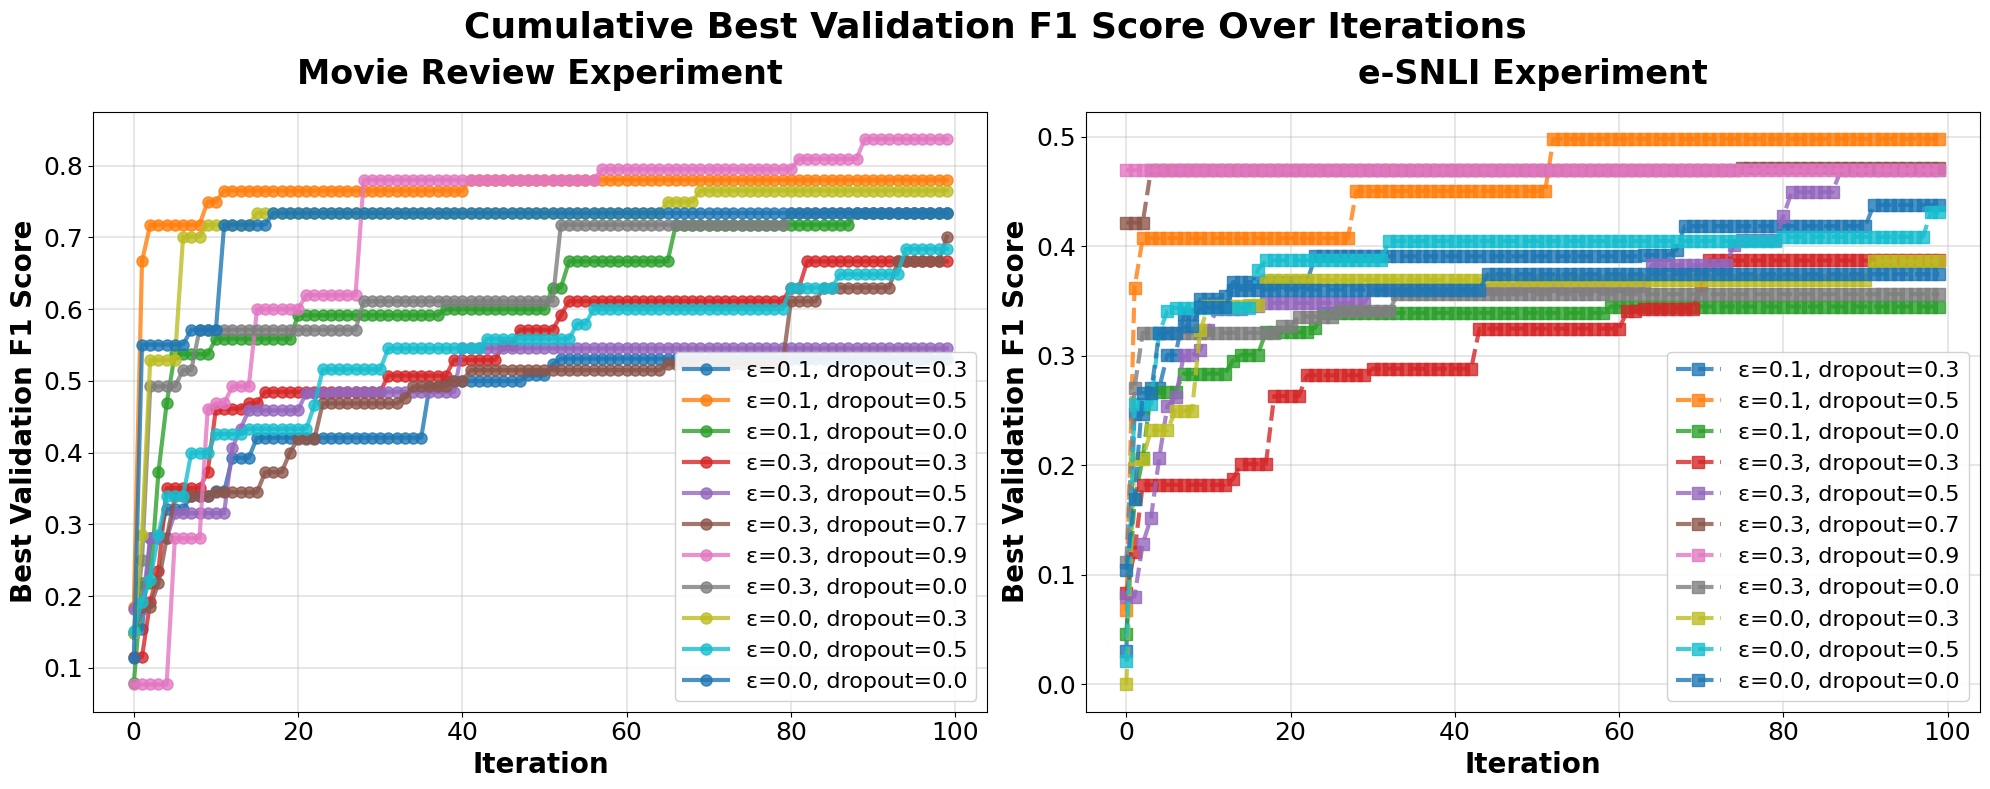

In [11]:
# Plot cumulative max F1 scores - directly in notebook
import json
import glob
import re
import matplotlib.pyplot as plt
import numpy as np

# Find all JSON files in both experiment folders
movie_files = glob.glob("movie_review_experiment/epsilon_*_max_*_iter_*.json")
esnli_files = glob.glob("esnli_experiment/epsilon_*_max_*_iter_*.json")

if not movie_files and not esnli_files:
    print("No JSON files found in experiment folders")
else:
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Process Movie Review experiment
    ax = axes[0]
    ax.set_title('Movie Review Experiment', fontsize=24, fontweight='bold', pad=20)
    
    for json_file in sorted(movie_files):
        try:
            # Extract epsilon and dropout from filename
            match = re.search(r'epsilon_([0-9.]+)_max_([0-9.]+)_iter_([0-9]+)\.json', json_file)
            if match:
                epsilon = float(match.group(1))
                dropout = float(match.group(2))
                max_iter = int(match.group(3))
            else:
                continue
            
            # Load the JSON file
            with open(json_file, 'r') as f:
                data = json.load(f)
            
            # Extract validation F1 scores from search history
            iterations = []
            validation_f1_scores = []
            
            for entry in data.get('search_history', []):
                iteration = entry.get('iteration', 0)
                metrics = entry.get('metrics', {})
                val_f1 = metrics.get('validation_f1_score', 0)
                
                iterations.append(iteration)
                validation_f1_scores.append(val_f1)
            
            if not validation_f1_scores:
                continue
            
            # Calculate cumulative maximum
            cumulative_max_scores = np.maximum.accumulate(validation_f1_scores)
            
            # Create label for the plot
            label = f"ε={epsilon}, dropout={dropout}"
            
            # Plot the CUMULATIVE MAXIMUM line
            ax.plot(iterations, cumulative_max_scores, marker='o', markersize=8, 
                    label=label, linewidth=3, alpha=0.8)
            
        except Exception as e:
            print(f"Error processing {json_file}: {e}")
    
    ax.set_xlabel('Iteration', fontsize=20, fontweight='bold')
    ax.set_ylabel('Best Validation F1 Score', fontsize=20, fontweight='bold')
    ax.legend(fontsize=16, loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3, linewidth=1.5)
    ax.tick_params(axis='both', which='major', labelsize=18)
    
    # Process e-SNLI experiment
    ax = axes[1]
    ax.set_title('e-SNLI Experiment', fontsize=24, fontweight='bold', pad=20)
    
    for json_file in sorted(esnli_files):
        try:
            # Extract epsilon and dropout from filename
            match = re.search(r'epsilon_([0-9.]+)_max_([0-9.]+)_iter_([0-9]+)\.json', json_file)
            if match:
                epsilon = float(match.group(1))
                dropout = float(match.group(2))
                max_iter = int(match.group(3))
            else:
                continue
            
            # Load the JSON file
            with open(json_file, 'r') as f:
                data = json.load(f)
            
            # Extract validation F1 scores from search history
            iterations = []
            validation_f1_scores = []
            
            for entry in data.get('search_history', []):
                iteration = entry.get('iteration', 0)
                metrics = entry.get('metrics', {})
                val_f1 = metrics.get('validation_f1_score', 0)
                
                iterations.append(iteration)
                validation_f1_scores.append(val_f1)
            
            if not validation_f1_scores:
                continue
            
            # Calculate cumulative maximum
            cumulative_max_scores = np.maximum.accumulate(validation_f1_scores)
            
            # Create label for the plot
            label = f"ε={epsilon}, dropout={dropout}"
            
            # Plot the CUMULATIVE MAXIMUM line
            ax.plot(iterations, cumulative_max_scores, marker='s', markersize=8, 
                    label=label, linewidth=3, alpha=0.8, linestyle='--')
            
        except Exception as e:
            print(f"Error processing {json_file}: {e}")
    
    ax.set_xlabel('Iteration', fontsize=20, fontweight='bold')
    ax.set_ylabel('Best Validation F1 Score', fontsize=20, fontweight='bold')
    ax.legend(fontsize=16, loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3, linewidth=1.5)
    ax.tick_params(axis='both', which='major', labelsize=18)
    
    # Overall title
    fig.suptitle('Cumulative Best Validation F1 Score Over Iterations', 
                 fontsize=26, fontweight='bold', y=0.98)
    plt.tight_layout()
    
    # SAVE BEFORE SHOWING
    plt.savefig('cumulative_max_f1_comparison.png', dpi=300, bbox_inches='tight')
    print("\nPlot saved as 'cumulative_max_f1_comparison.png'")
    
    # Show the plot
    plt.show()


## Analysis: Distinct Actions vs Dropout Rate

This section analyzes the relationship between dropout rate and the number of distinct actions taken during prompt optimization for both experiments.

In [7]:
import json
import glob
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from scipy.stats import pearsonr

def parse_filename(filename):
    """Extract epsilon, dropout, and iterations from filename"""
    pattern = r'epsilon_([\d.]+)_max_([\d.]+)_iter_(\d+)\.json'
    match = re.search(pattern, filename)
    if match:
        return {
            'epsilon': float(match.group(1)),
            'dropout': float(match.group(2)),
            'iterations': int(match.group(3))
        }
    return None

def get_action_distribution(file_path):
    """Get the distribution of actions taken in a single experiment file"""
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Extract actions from search_history
    actions = []
    if 'search_history' in data:
        for iteration in data['search_history']:
            if 'action' in iteration:
                actions.append(iteration['action'])
    
    # Count action occurrences
    action_counts = Counter(actions)
    return action_counts

def calculate_concentration_metrics(action_counts):
    """Calculate metrics for action concentration/repetition"""
    if not action_counts or sum(action_counts.values()) == 0:
        return {
            'max_action_proportion': 0,
            'top3_proportion': 0,
            'repetition_index': 0,
            'distinct_actions': 0
        }
    
    counts = np.array(list(action_counts.values()))
    total = counts.sum()
    sorted_counts = np.sort(counts)[::-1]
    
    # Proportion of the most frequently selected action (lower = better)
    max_action_proportion = sorted_counts[0] / total
    
    # Proportion of top 3 most frequent actions (lower = better)
    top3_proportion = sum(sorted_counts[:min(3, len(sorted_counts))]) / total
    
    # Repetition index: how much the top action dominates (1.0 = perfect uniformity)
    mean_count = total / len(counts)
    repetition_index = sorted_counts[0] / mean_count if mean_count > 0 else 0
    
    # Number of distinct actions used
    distinct_actions = len(action_counts)
    
    return {
        'max_action_proportion': max_action_proportion,
        'top3_proportion': top3_proportion,
        'repetition_index': repetition_index,
        'distinct_actions': distinct_actions
    }

def analyze_epsilon_03(experiment_folder):
    """Analyze only epsilon=0.3 experiments across all dropout values"""
    files = glob.glob(f'{experiment_folder}/epsilon_0.3_*.json')
    results = []
    
    for file in sorted(files):
        params = parse_filename(file)
        if params and params['epsilon'] == 0.3:
            action_counts = get_action_distribution(file)
            metrics = calculate_concentration_metrics(action_counts)
            results.append({
                **params,
                **metrics,
                'action_counts': action_counts,
                'file': file
            })
    
    return results

# Analyze both experiments (epsilon=0.3 only)
movie_results = analyze_epsilon_03('movie_review_experiment')
esnli_results = analyze_epsilon_03('esnli_experiment')

print(f"\n{'='*80}")
print(f"DROPOUT EFFECTIVENESS ANALYSIS (Epsilon = 0.3)")
print(f"{'='*80}")
print("\nGoal: Does dropout prevent repeated selection of the same action?")
print("Expected: As dropout increases → action concentration decreases")
print(f"{'='*80}\n")


DROPOUT EFFECTIVENESS ANALYSIS (Epsilon = 0.3)

Goal: Does dropout prevent repeated selection of the same action?
Expected: As dropout increases → action concentration decreases



In [8]:
# Summary Table
print("\nMOVIE REVIEW EXPERIMENT (ε=0.3):")
print(f"{'Dropout':<12}{'Distinct':<12}{'Max Action %':<15}{'Top3 %':<12}{'Repetition':<12}")
print("-" * 63)
for r in sorted(movie_results, key=lambda x: x['dropout']):
    print(f"{r['dropout']:<12.1f}{r['distinct_actions']:<12}{r['max_action_proportion']:<15.3f}"
          f"{r['top3_proportion']:<12.3f}{r['repetition_index']:<12.3f}")

print("\n\nE-SNLI EXPERIMENT (ε=0.3):")
print(f"{'Dropout':<12}{'Distinct':<12}{'Max Action %':<15}{'Top3 %':<12}{'Repetition':<12}")
print("-" * 63)
for r in sorted(esnli_results, key=lambda x: x['dropout']):
    print(f"{r['dropout']:<12.1f}{r['distinct_actions']:<12}{r['max_action_proportion']:<15.3f}"
          f"{r['top3_proportion']:<12.3f}{r['repetition_index']:<12.3f}")

print("\n" + "="*80)
print("Metric Interpretation:")
print("="*80)
print("• Distinct Actions: Number of unique actions used (Higher = more diversity)")
print("• Max Action %: Most frequent action as % of total (Lower = less repetition)")
print("• Top3 %: Top 3 actions as % of total (Lower = more distributed)")
print("• Repetition Index: Most frequent / average (1.0 = perfect uniformity)")
print("\nDropout is WORKING if these metrics improve (move in desired direction) as dropout increases")
print("="*80)


MOVIE REVIEW EXPERIMENT (ε=0.3):
Dropout     Distinct    Max Action %   Top3 %      Repetition  
---------------------------------------------------------------
0.0         17          0.280          0.600       4.760       
0.3         18          0.230          0.510       4.140       
0.5         20          0.270          0.560       5.400       
0.7         22          0.130          0.360       2.860       
0.9         29          0.090          0.240       2.610       


E-SNLI EXPERIMENT (ε=0.3):
Dropout     Distinct    Max Action %   Top3 %      Repetition  
---------------------------------------------------------------
0.0         19          0.280          0.650       5.320       
0.3         24          0.230          0.470       5.520       
0.5         17          0.210          0.550       3.570       
0.7         22          0.150          0.400       3.300       
0.9         27          0.090          0.260       2.430       

Metric Interpretation:
• Distinct Action


Plot saved as: epsilon03_action_distribution.png


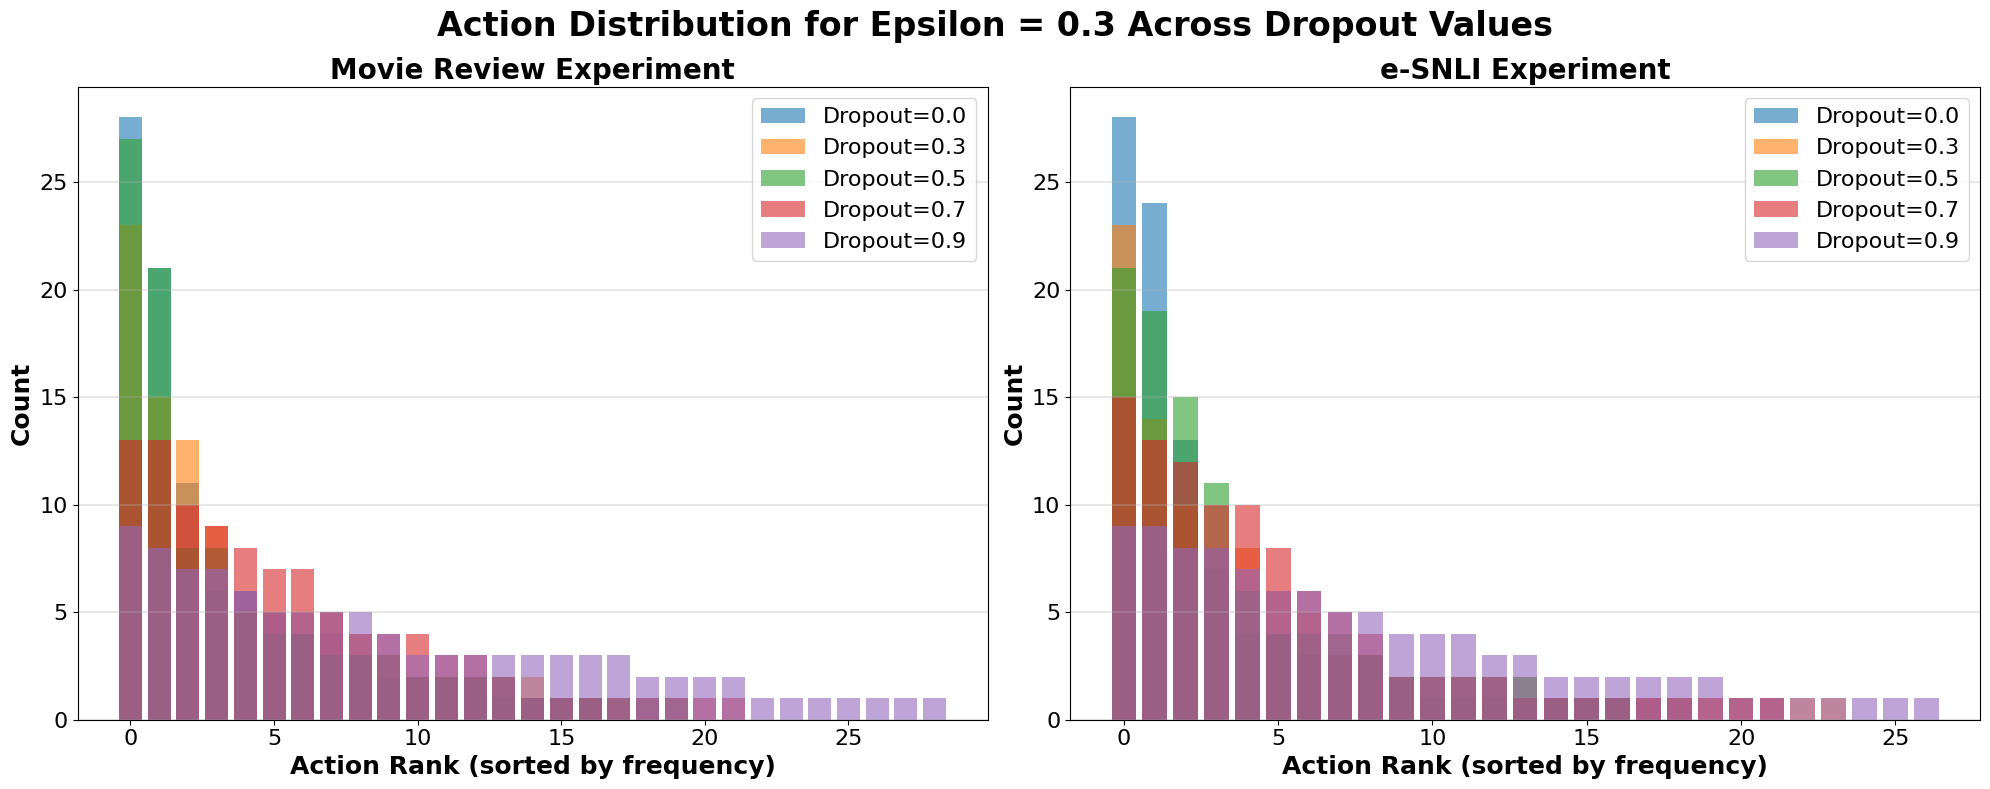

In [12]:
# Visualize action distributions for epsilon=0.3 across all dropout values
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Action Distribution for Epsilon = 0.3 Across Dropout Values', 
             fontsize=24, fontweight='bold')

# Movie Review
ax = axes[0]
ax.set_title('Movie Review Experiment', fontsize=20, fontweight='bold')
for r in sorted(movie_results, key=lambda x: x['dropout']):
    action_counts = r['action_counts']
    actions = list(action_counts.keys())
    counts = list(action_counts.values())
    
    # Sort by count for better visualization
    sorted_pairs = sorted(zip(actions, counts), key=lambda x: x[1], reverse=True)
    actions, counts = zip(*sorted_pairs) if sorted_pairs else ([], [])
    
    ax.bar(range(len(actions)), counts, alpha=0.6, 
           label=f"Dropout={r['dropout']:.1f}")

ax.set_xlabel('Action Rank (sorted by frequency)', fontsize=18, fontweight='bold')
ax.set_ylabel('Count', fontsize=18, fontweight='bold')
ax.legend(fontsize=16, loc='best')
ax.grid(True, alpha=0.3, axis='y', linewidth=1.5)
ax.tick_params(axis='both', which='major', labelsize=16)

# e-SNLI
ax = axes[1]
ax.set_title('e-SNLI Experiment', fontsize=20, fontweight='bold')
for r in sorted(esnli_results, key=lambda x: x['dropout']):
    action_counts = r['action_counts']
    actions = list(action_counts.keys())
    counts = list(action_counts.values())
    
    # Sort by count for better visualization
    sorted_pairs = sorted(zip(actions, counts), key=lambda x: x[1], reverse=True)
    actions, counts = zip(*sorted_pairs) if sorted_pairs else ([], [])
    
    ax.bar(range(len(actions)), counts, alpha=0.6,
           label=f"Dropout={r['dropout']:.1f}")

ax.set_xlabel('Action Rank (sorted by frequency)', fontsize=18, fontweight='bold')
ax.set_ylabel('Count', fontsize=18, fontweight='bold')
ax.legend(fontsize=16, loc='best')
ax.grid(True, alpha=0.3, axis='y', linewidth=1.5)
ax.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.savefig('epsilon03_action_distribution.png', dpi=300, bbox_inches='tight')
print("\nPlot saved as: epsilon03_action_distribution.png")
plt.show()


## Dropout Effectiveness Analysis (Epsilon = 0.3)

**Research Question**: Does dropout prevent the model from repeatedly selecting the same "favorite" action?

**Hypothesis**: As dropout rate increases, the model should be forced to explore different actions, resulting in:
- More distinct actions used
- Lower concentration on the most frequent action
- More uniform distribution across all actions


Plot saved as: dropout_effectiveness_epsilon03.png


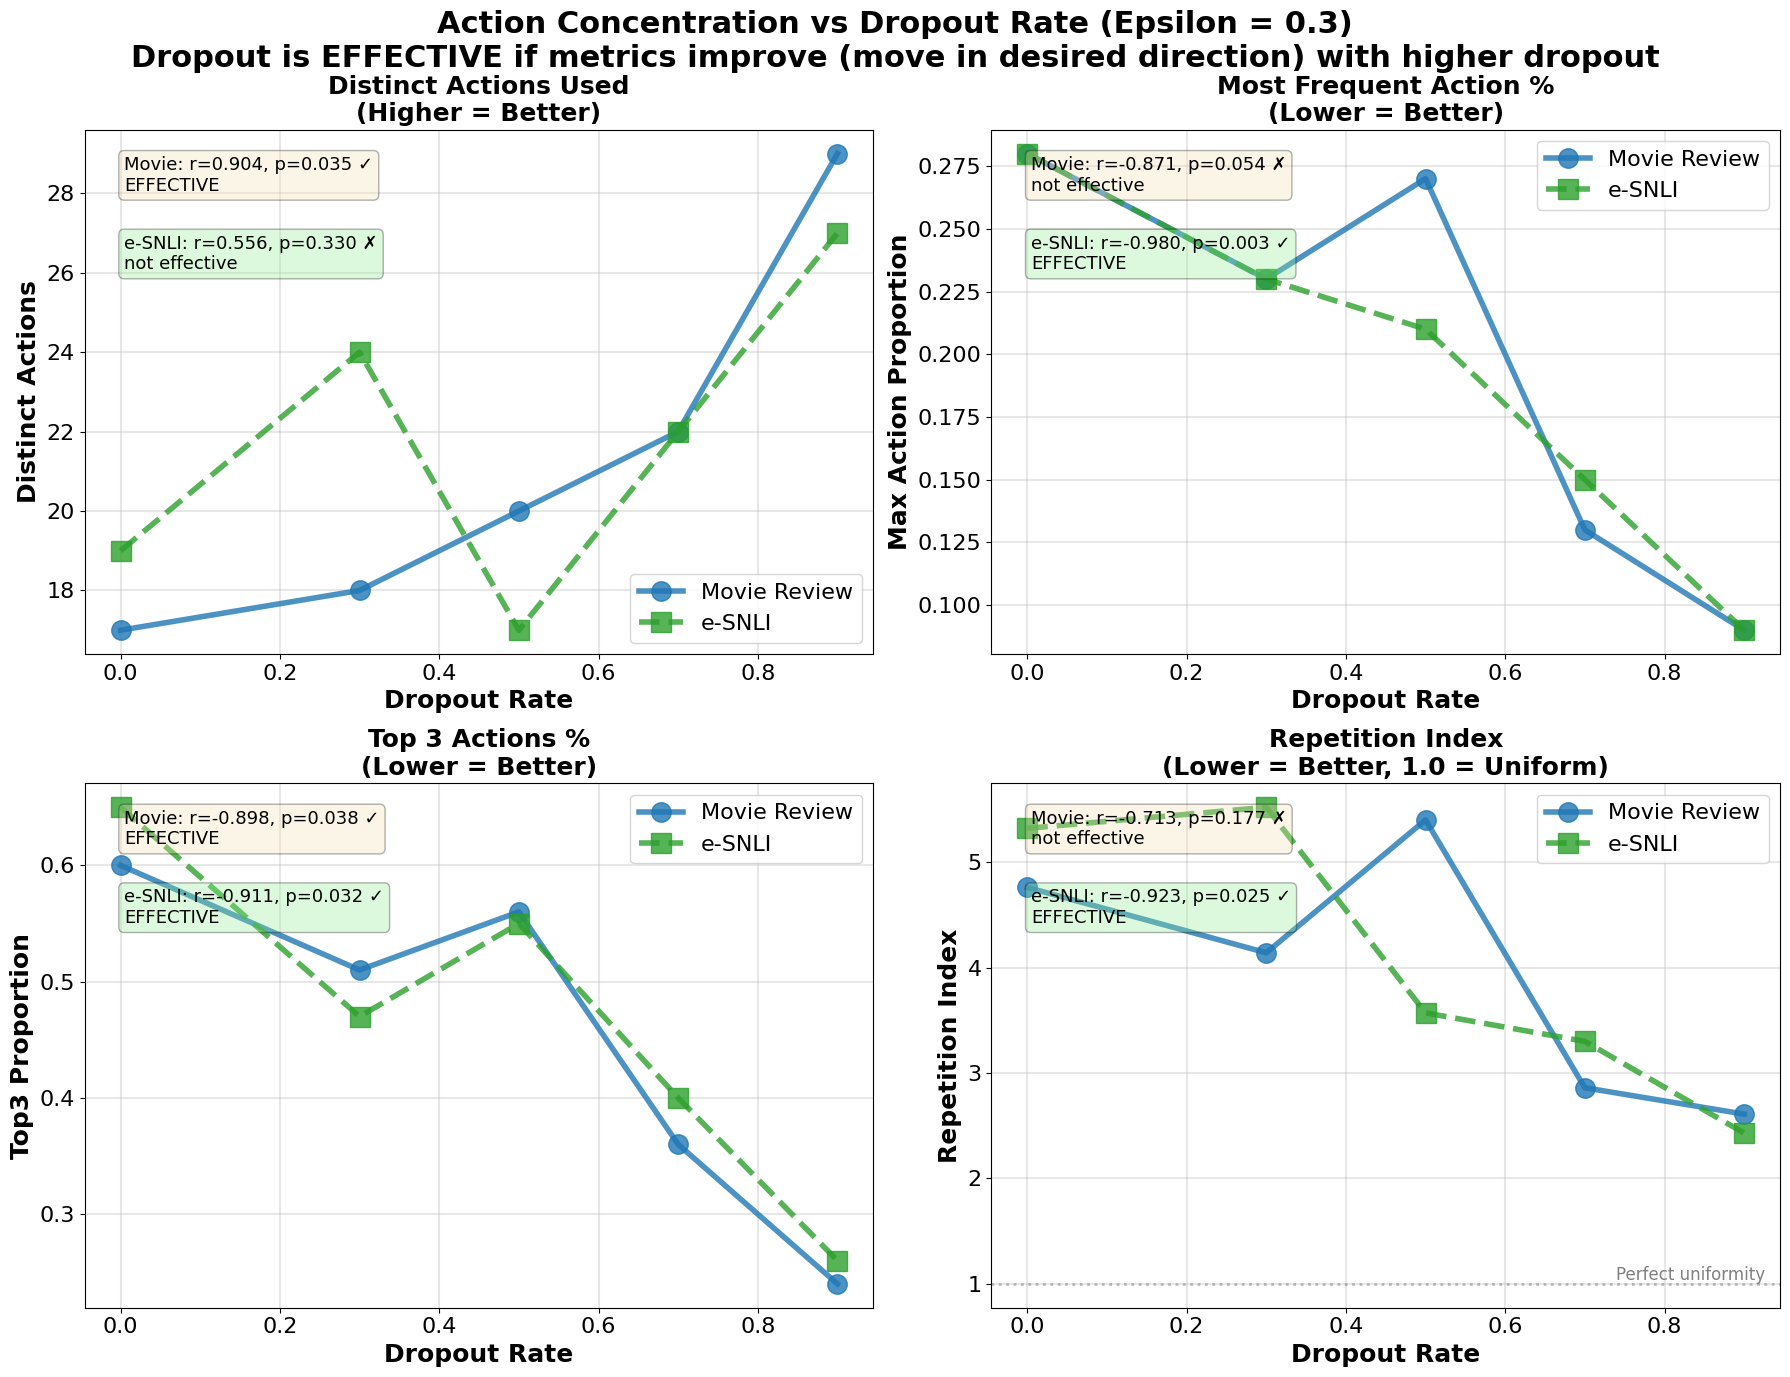

In [13]:
# Visualize concentration metrics vs dropout rate
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Action Concentration vs Dropout Rate (Epsilon = 0.3)\n' +
             'Dropout is EFFECTIVE if metrics improve (move in desired direction) with higher dropout', 
             fontsize=22, fontweight='bold')

metrics = [
    ('distinct_actions', 'Distinct Actions Used\n(Higher = Better)', 0, 0, 'up'),
    ('max_action_proportion', 'Most Frequent Action %\n(Lower = Better)', 0, 1, 'down'),
    ('top3_proportion', 'Top 3 Actions %\n(Lower = Better)', 1, 0, 'down'),
    ('repetition_index', 'Repetition Index\n(Lower = Better, 1.0 = Uniform)', 1, 1, 'down')
]

for metric_name, metric_title, row, col, desired_direction in metrics:
    ax = axes[row, col]
    
    # Plot Movie Review
    if movie_results:
        dropouts_m = [r['dropout'] for r in sorted(movie_results, key=lambda x: x['dropout'])]
        values_m = [r[metric_name] for r in sorted(movie_results, key=lambda x: x['dropout'])]
        
        ax.plot(dropouts_m, values_m, marker='o', linewidth=4, markersize=14, 
                label='Movie Review', color='#1f77b4', alpha=0.8)
        
        # Calculate correlation
        if len(dropouts_m) > 1:
            r, p = pearsonr(dropouts_m, values_m)
            is_effective = (r > 0 and desired_direction == 'up') or (r < 0 and desired_direction == 'down')
            sig = "✓" if p < 0.05 else "✗"
            eff = "EFFECTIVE" if is_effective and p < 0.05 else "not effective"
            ax.text(0.05, 0.95, f'Movie: r={r:.3f}, p={p:.3f} {sig}\n{eff}', 
                   transform=ax.transAxes, fontsize=13, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    # Plot e-SNLI
    if esnli_results:
        dropouts_e = [r['dropout'] for r in sorted(esnli_results, key=lambda x: x['dropout'])]
        values_e = [r[metric_name] for r in sorted(esnli_results, key=lambda x: x['dropout'])]
        
        ax.plot(dropouts_e, values_e, marker='s', linewidth=4, markersize=14,
                label='e-SNLI', color='#2ca02c', alpha=0.8, linestyle='--')
        
        # Calculate correlation
        if len(dropouts_e) > 1:
            r, p = pearsonr(dropouts_e, values_e)
            is_effective = (r > 0 and desired_direction == 'up') or (r < 0 and desired_direction == 'down')
            sig = "✓" if p < 0.05 else "✗"
            eff = "EFFECTIVE" if is_effective and p < 0.05 else "not effective"
            ax.text(0.05, 0.80, f'e-SNLI: r={r:.3f}, p={p:.3f} {sig}\n{eff}', 
                   transform=ax.transAxes, fontsize=13, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
    
    ax.set_title(metric_title, fontsize=18, fontweight='bold')
    ax.set_xlabel('Dropout Rate', fontsize=18, fontweight='bold')
    ax.set_ylabel(metric_name.replace('_', ' ').title(), fontsize=18, fontweight='bold')
    ax.legend(fontsize=16, loc='best')
    ax.grid(True, alpha=0.3, linewidth=1.5)
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    # Add reference line for repetition index
    if metric_name == 'repetition_index':
        ax.axhline(y=1.0, color='gray', linestyle=':', alpha=0.5, linewidth=2)
        ax.text(ax.get_xlim()[1]*0.98, 1.0, 'Perfect uniformity', 
               fontsize=12, va='bottom', ha='right', color='gray')

plt.tight_layout()
plt.savefig('dropout_effectiveness_epsilon03.png', dpi=300, bbox_inches='tight')
print("\nPlot saved as: dropout_effectiveness_epsilon03.png")
plt.show()


In [ ]:
# Statistical Summary
print("\n" + "="*80)
print("STATISTICAL CORRELATION ANALYSIS")
print("="*80)
print("\nFor dropout to be EFFECTIVE at preventing action repetition:")
print("  • Distinct Actions: POSITIVE correlation (more dropout → more diversity)")
print("  • Max Action %: NEGATIVE correlation (more dropout → less concentration)")
print("  • Top3 %: NEGATIVE correlation (more dropout → more distributed)")
print("  • Repetition Index: NEGATIVE correlation (more dropout → less repetition)")
print("  • Statistical significance: p < 0.05")
print("="*80)

def analyze_correlations(results, experiment_name):
    print(f"\n{experiment_name}:")
    print("-" * 80)
    
    if len(results) < 2:
        print("  Not enough data points for correlation analysis")
        return
    
    dropouts = [r['dropout'] for r in sorted(results, key=lambda x: x['dropout'])]
    
    metrics = [
        ('distinct_actions', 'positive'),
        ('max_action_proportion', 'negative'),
        ('top3_proportion', 'negative'),
        ('repetition_index', 'negative')
    ]
    
    effective_count = 0
    for metric_name, desired_direction in metrics:
        values = [r[metric_name] for r in sorted(results, key=lambda x: x['dropout'])]
        
        if len(set(values)) > 1:
            r_val, p_val = pearsonr(dropouts, values)
            
            # Check if correlation is in the desired direction
            is_right_direction = (r_val > 0 and desired_direction == 'positive') or \
                                (r_val < 0 and desired_direction == 'negative')
            
            is_significant = p_val < 0.05
            
            if is_right_direction and is_significant:
                status = "✓ EFFECTIVE"
                effective_count += 1
            elif is_right_direction:
                status = "~ right direction, not significant"
            else:
                status = "✗ wrong direction"
            
            print(f"  {metric_name:25s}: r={r_val:7.3f}, p={p_val:.3f}  [{status}]")
    
    print(f"\n  Summary: {effective_count}/4 metrics show dropout is statistically effective")
    return effective_count

movie_effective = analyze_correlations(movie_results, "MOVIE REVIEW (ε=0.3)")
esnli_effective = analyze_correlations(esnli_results, "E-SNLI (ε=0.3)")

print("\n" + "="*80)
print("OVERALL CONCLUSION")
print("="*80)
if movie_results:
    print(f"Movie Review: {movie_effective}/4 metrics support dropout effectiveness")
if esnli_results:
    print(f"e-SNLI: {esnli_effective}/4 metrics support dropout effectiveness")
print("\nDropout is considered EFFECTIVE if at least 3/4 metrics show:")
print("  1. Correlation in the correct direction")
print("  2. Statistical significance (p < 0.05)")
print("="*80)


STATISTICAL CORRELATION ANALYSIS

For dropout to be EFFECTIVE at preventing action repetition:
  • Distinct Actions: POSITIVE correlation (more dropout → more diversity)
  • Max Action %: NEGATIVE correlation (more dropout → less concentration)
  • Top3 %: NEGATIVE correlation (more dropout → more distributed)
  • Repetition Index: NEGATIVE correlation (more dropout → less repetition)
  • Statistical significance: p < 0.05

MOVIE REVIEW (ε=0.3):
--------------------------------------------------------------------------------
  distinct_actions         : r=  0.904, p=0.035  [✓ EFFECTIVE]
  max_action_proportion    : r= -0.871, p=0.054  [~ right direction, not significant]
  top3_proportion          : r= -0.898, p=0.038  [✓ EFFECTIVE]
  repetition_index         : r= -0.713, p=0.177  [~ right direction, not significant]

  Summary: 2/4 metrics show dropout is statistically effective

E-SNLI (ε=0.3):
--------------------------------------------------------------------------------
  distin